In [188]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pywt
import wfdb
import math
import sklearn
import keras.backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from skimage.restoration import denoise_wavelet
from random import shuffle
from tqdm import tqdm

In [189]:
tags_ecg_feas1 = pd.read_csv(r"Data\\feas1\\rec_data_anon.csv")
tags_pt_feas1 = pd.read_csv(r"Data\\feas1\\pt_data_anon.csv")
key_1 = {'AF':2, 'maybeAF':3, 'noAF':4, 'other':1, 'undecided':6}
tags_ecg_feas2 = pd.read_csv(r"Data\\feas2\\rec_data_anon.csv")
tags_pt_feas2 = pd.read_csv(r"Data\\feas2\\pt_data_anon.csv")
key_2 = {'AF':1, 'maybeAF':2, 'noAF':3, 'noisy':4, 'undecided':6}
tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")
tags_pt_trial = pd.read_csv(r"Data\\trial\\pt_data_anon.csv")
key_t = {'AF':1, 'maybeAF':2, 'noAF':3, 'other':4, 'noisy':5, 'undecided':6}

C:\Users\docto\AppData\Local\Temp\ipykernel_51664\3583887908.py:7: DtypeWarning: Columns (35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")


In [254]:
def generate_filter(fs=500, low_cut=0.6, high_cut=40, N=1):
    return signal.butter(N=N, Wn=[low_cut, high_cut], btype='bandpass', analog=False, output='sos', fs=fs)
    # return signal.butter(N=N, Wn=high_cut, btype='lowpass', analog=False, output='sos', fs=fs)

def apply_filters(ecg_signal, sos):
    return signal.sosfilt(sos, ecg_signal)

def filter_signal(ecg_signal, sos, N=5):
    ecg_filtered = remove_trend(ecg_signal)
    if N:
        for _ in range(N):
            ecg_filtered = apply_filters(ecg_filtered, sos)
    else:
        ecg_filtered = apply_filters(ecg_filtered, sos)
    return ecg_filtered

def remove_trend(ecg_signal, levels=8):
    DWTcoeffs = pywt.wavedec(ecg_signal, 'sym3')
    print(len(DWTcoeffs))
    for i in range(1,levels):
        DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])
    ecg_filtered = np.array(ecg_signal) - pywt.waverec(DWTcoeffs,'sym3',mode='symmetric',axis=-1)
    return ecg_filtered

def normalise_signals(ecg_signals):
    norm_ecg_signals = []
    for i in ecg_signals:
        norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))
    return norm_ecg_signals

def remove_jumps(ecg_signal_orig):
    ecg_signal = np.copy(ecg_signal_orig)
    diff = np.diff(ecg_signal)
    avg_diff = np.average(np.abs(diff))
    for j, i in enumerate(diff):
        if j < 50: 
            if i > 3*avg_diff:
                # if -np.ptp(ecg_signal[j+1:j+50]) < 0.5*i or i > 6*avg_diff:
                if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                    ecg_signal[j+1:] -= i
            elif i < -3*avg_diff:
                if j == 0:
                    ecg_signal[j+1:] -= i
                elif np.max(diff[:j]) < -0.5*i or i < -6*avg_diff:
                    ecg_signal[j+1:] -= i
        elif i > 3*avg_diff:
            if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                ecg_signal[j+1:] -= i
        elif i < -3*avg_diff:
            if np.max(diff[j-50:j]) < -0.5*i or i < -6*avg_diff:
                ecg_signal[j+1:] -= i
    return ecg_signal

def filter_signals(ecg_signals, low_cut=0.6, high_cut=40, N=1):
    sos = generate_filter(low_cut=low_cut, high_cut=high_cut, N=N)
    ecg_signals_filtered = [None]*len(ecg_signals)
    for j in range(len(ecg_signals)):
        ecg_signals_filtered[j] = filter_signal(remove_jumps(ecg_signals[j]), sos)
    return normalise_signals(np.array(ecg_signals_filtered))
    
def performance(y_true, y_pred):
    TP = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 1])
    FP = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 1])
    FN = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 0])
    TN = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 0])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*(precision*recall)/(precision + recall)

    return [f1_score, precision, recall, [[TP, FP], [FN, TN]]]

In [191]:
class ecg:

    def __init__(self, tags_ecg_feas1 = tags_ecg_feas1, tags_pt_feas1 = tags_pt_feas1, 
                 tags_ecg_feas2 = tags_ecg_feas2, tags_pt_feas2 = tags_pt_feas2, 
                 key_1 = key_1, key_2 = key_2):
        self.tags_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1))
        self.tags_pt_1 = np.array(pd.DataFrame(tags_pt_feas1))
        self.tags_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2))
        self.tags_pt_2 = np.array(pd.DataFrame(tags_pt_feas2))
        self.tags_ecg_t = np.array(pd.DataFrame(tags_ecg_trial))
        self.tags_pt_t = np.array(pd.DataFrame(tags_pt_trial))

        self.tags_pt_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_info_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_info_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_info_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_diag_1 = np.array(pd.DataFrame(tags_pt_feas1, columns=['ptID', 'ptDiag']))
        self.tags_pt_diag_2 = np.array(pd.DataFrame(tags_pt_feas2, columns=['ptID', 'ptDiag']))
        self.tags_pt_diag_t = np.array(pd.DataFrame(tags_pt_trial, columns=['ptID', 'ptDiag']))
        self.tags_ecg_info_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))
        self.tags_ecg_info_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['measID', 'measDiag', 'ptDiag']))
        self.tags_ecg_info_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))

        self.key_1 = key_1
        self.key_2 = key_2
        self.key_t = key_t
        self.ecg_num_1 = 162515
        self.ecg_num_2 = 23253
        self.ecg_num_t = 1098286
        self.pt_num_1 = 2141
        self.pt_num_2 = 288
        self.pt_num_t = 13386

    def extract_signal(self, measID, study = 'feas1'):
        if study == 'feas1':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_1, self.ecg_num_1, 'saferF1_pt'
        elif study == 'feas2':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_2, self.ecg_num_2, 'saferF2_pt'
        elif study == 'trial':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_t, self.ecg_num_t, 'saferT_pt'

        assert measID < num_ecgs and measID == ecg_IDs[measID-1,-1]
        ptID, measNo = ecg_IDs[measID-1,0], ecg_IDs[measID-1,1]
        ptID_vis, folder_vis = self.file_strs(ptID)

        try:
            ecg_signal = wfdb.rdrecord('E:\\IIB-data\\ECGs\\'+study+'\\'+folder_vis+'\\'+file_head+ptID_vis)
        except FileNotFoundError:
            # print('Incorrect .dat file assigned to patient '+str(ptID)+' for study '+study)
            return
        except TypeError:
            # print('Weird error for measID '+str(measID)+' for study '+study)
            return
        
        if len(ecg_signal.p_signal[0]) < measNo:
            print('Expected measurement '+str(measNo)+' for patient '+str(ptID)+' for study '+study+' not in file')
        else:
            return np.array(ecg_signal.p_signal[:,measNo-1])
    
    def file_strs(self, ptID):
        ptID_vis = '0'*(6-len(str(ptID)))+str(ptID)
        folder_vis = '0'*(4-len(str(ptID//100)))+str(ptID//100)+'0'*2
        return ptID_vis, folder_vis
        
    def extract_tags(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            if measID_num > self.ecg_num_2: raise Exception('Not a valid measID')
            tags = self.tags_ecg_2[measID_num-1]
        elif study == 'feas1':
            if measID_num > self.ecg_num_1: raise Exception('Not a valid measID')
            tags = self.tags_ecg_1[measID_num-1]
        elif study == 'trial':
            if measID_num > self.ecg_num_t: raise Exception('Not a valid measID')
            tags = self.tags_ecg_t[measID_num-1]
        assert tags['measID'] == measID_num                   
        return tags
    
    def extract_label(self, tags):
        return tags['measDiag']
    
    def extract_ptDiag(self, ptID, study = 'trial'):
        if study == 'feas1':
            pt_info = self.tags_pt_diag_1
        elif study == 'feas2':
            pt_info = self.tags_pt_diag_2
        elif study == 'trial':
            pt_info = self.tags_pt_diag_t

        assert pt_info[ptID-1][0] == ptID
        return pt_info[ptID-1][1]
    
    def extract_measDiag(self, measIDs, study = 'trial'):
        if study == 'feas1':
            pt_info = self.tags_pt_info_1
        elif study == 'feas2':
            pt_info = self.tags_pt_info_2
        elif study == 'trial':
            pt_info = self.tags_pt_info_t

        measDiags = []
        for i in measIDs:
            assert pt_info[i-1][2] == i
            measDiags.append(pt_info[i-1][3])
        return measDiags
    
    def extract_cardiolund_tags(self, tags, study = 'feas2'):
        if study == 'feas2':
            cld_tags = list(tags.iloc[22:37]) 
        elif study == 'feas1':
            cld_tags =  list(tags.iloc[25:40])
        elif study == 'trial':
            cld_tags =  list(tags.iloc[25:40])
        if any(math.isnan(cld_tags)):
            return None
        else:
            return cld_tags
        
    def test_clean(self, measID, study = 'feas2'):
        if study == 'feas2':
            cld_tags = self.tags_ecg_2[measID-1][23:35]
        elif study == 'feas1':
            cld_tags =  self.tags_ecg_1[measID-1][26:46]
        elif study == 'trial':
            cld_tags =  self.tags_ecg_t[measID-1][23:35]
            
        if all(cld_tags == 0):
            return True
        else:
            return False
        
    def test_noisy(self, measID, study = 'trial'):
        if study == 'feas2':
            cld_noisy = self.tags_ecg_2[measID-1][30]
            diag = self.tags_ecg_2[measID-1][15]
        elif study == 'feas1':
            cld_noisy =  self.tags_ecg_1[measID-1][33]
            diag = self.tags_ecg_1[measID-1][18]
        elif study == 'trial':
            cld_noisy =  self.tags_ecg_t[measID-1][30]
            diag = self.tags_ecg_t[measID-1][15]
            
        if cld_noisy == 1 or diag == 5:
            return True
        else:
            return False
    
    def extract_pt_measIDs(self, ptID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
            ecg_num = self.ecg_num_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
            ecg_num = self.ecg_num_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_ecg_t
            ecg_num = self.ecg_num_t
        ptID_measIDs = []
        i = [j[0] for j in tags_ecg].index(ptID_num)
        while i < ecg_num-1 and tags_ecg[i][0] == ptID_num:
            ptID_measIDs.append(tags_ecg[i][-1])
            i += 1
        return ptID_measIDs
    
    def extract_measID_pt(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_ecg_t
        return [j[0] for j in tags_ecg if j[2] == measID_num][0]
    
    def extract_measIDs(self, tag = 'AF', study = 'feas2', clean = True):
        if study == 'feas1':
            tags_ecg, key = self.tags_ecg_info_1, self.key_1
        elif study == 'feas2':
            tags_ecg, key = self.tags_ecg_info_2, self.key_2
        elif study == 'trial':
            tags_ecg, key = self.tags_ecg_info_t, self.key_t

        diag = key[tag]
        if tag == 'noAF':
            measIDs = [i[0] for i in tags_ecg if i[1] == diag]
            if clean:
                return [i for i in measIDs if self.test_clean(i, study=study)]
            else:
                # return [i for i in measIDs if not self.test_clean(i, study=study)]
                return measIDs
        else:
            return [i[0] for i in tags_ecg if i[1] == diag]
    
    def extract_ptIDs(self, tag = 'AF', study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_info_2
            key = self.key_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_info_1
            key = self.key_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_info_t
            key = self.key_t
        
        diag = key[tag]
        return [i[0] for i in tags_ecg if i[1] == diag]
    
    def store_ecg_tags(self, tag = 'AF', study = 'feas2', measIDs = None):
        if measIDs is None: 
            measIDs = self.extract_measIDs(tag=tag, study=study)
        data = []
        for i in measIDs:
            tags = self.extract_tags(i, study = study)
            cdl_tags = self.extract_cardiolund_tags(tags, study = study)
            if cdl_tags is not None:
                data.append(cdl_tags)
        return data
    
    def store_ecg_data(self, tag = 'AF', study = 'feas2', measIDs = None, length = None, clean = True, permute = True):
        if type(measIDs) != list:
            measIDs = self.extract_measIDs(tag=tag, study=study, clean=clean)

        if length and length < len(measIDs):
            measIDs = np.random.permutation(measIDs)[:length]
        elif permute:
            measIDs = np.random.permutation(measIDs)

        data = []
        for i in tqdm(measIDs):
            extracted_signal = self.extract_signal(i, study=study)
            if type(extracted_signal) == np.ndarray:
                data.append(extracted_signal)
        return data, measIDs


In [192]:
ecg = ecg()

In [193]:
# Find all meas viewed by cardiologists

ecg_tags_reviewed = [i for i in ecg.tags_pt_info_t if i[3] != 6]
ecg_tags_AF = [i for i in ecg_tags_reviewed if i[3] == 1]

In [194]:
# Convert to list of patients viewed, and list of patients with AF

print(len(ecg_tags_reviewed))
patients_expanded = [j[0] for j in ecg_tags_reviewed]
patients_expanded_AF = [j[0] for j in ecg_tags_AF]
patients_reviewed = [i for i in range(13453) if i in patients_expanded]
patients_AF = [i for i in range(13453) if i in patients_expanded_AF]
print(len(patients_reviewed), len(patients_AF))

69963
6544 461


In [195]:
# Select 3/4 of patients for CNN training, leave 1/4 for testing

shuffle(patients_reviewed)
ntrain_CNN = round(len(patients_reviewed)*3/4)
pt_train = patients_reviewed[:ntrain_CNN]
pt_test = patients_reviewed[ntrain_CNN:]
print(len(pt_train), len(pt_test))
print(sum([1 for i in pt_train if i in patients_AF]), sum([1 for i in pt_test if i in patients_AF]))

4908 1636
353 108


In [196]:
# Convert list of patients to list of measIDs

meas_train = [i[2] for i in ecg_tags_reviewed if i[0] in pt_train]
meas_test = [i[2] for i in ecg.tags_pt_info_t if i[0] in pt_test and (not ecg.test_clean(i[2], study = 'trial') and i[3] != 5)]
pt_test_expanded = [i[0] for i in ecg.tags_pt_info_t if i[0] in pt_test and (not ecg.test_clean(i[2], study = 'trial') and i[3] != 5)]

print(len(meas_test))

41735


In [197]:
data_AF_feas1, measIDs_AF_feas1 = ecg.store_ecg_data(tag='AF', study='feas1')
data_noAF_feas1, measIDs_noAF_feas1 = ecg.store_ecg_data(tag='noAF', study='feas1', clean=False)
print(len(measIDs_AF_feas1), len(measIDs_noAF_feas1))

data_AF_trial_u, measIDs_AF_trial_u = ecg.store_ecg_data(tag='AF', study='trial')
data_noAF_trial_u, measIDs_noAF_trial_u = ecg.store_ecg_data(tag='noAF', study='trial', length=10000, clean=False)
print(len(measIDs_AF_trial_u), len(measIDs_noAF_trial_u))

100%|██████████| 3127/3127 [01:53<00:00, 27.47it/s]


822 3127


100%|██████████| 10000/10000 [06:26<00:00, 25.84it/s]


2387 10000


In [205]:
# Split data into CNN and for testing

train_AF_idxs = []
test_AF_idxs = []
train_noAF_idxs = []
test_noAF_idxs = []

for i in range(len(measIDs_AF_trial_u)):
    if measIDs_AF_trial_u[i] in meas_train:
        train_AF_idxs.append(i)
    elif measIDs_AF_trial_u[i] in meas_test:
        test_AF_idxs.append(i)
    else:
        print(measIDs_AF_trial_u[i], 'AF Error')

for i in range(len(measIDs_noAF_trial_u)):
    if measIDs_noAF_trial_u[i] in meas_train:
        train_noAF_idxs.append(i)
    elif measIDs_noAF_trial_u[i] in meas_test:
        test_noAF_idxs.append(i)
    else:
        print(measIDs_noAF_trial_u[i], 'no AF Error')

measIDs_pt_test_AF, data_AF_trial, measIDs_AF_trial = np.array(measIDs_AF_trial_u)[test_AF_idxs], np.array(data_AF_trial_u)[train_AF_idxs, :], np.array(measIDs_AF_trial_u)[train_AF_idxs]
measIDs_pt_test_noAF, data_noAF_trial, measIDs_noAF_trial = np.array(measIDs_noAF_trial_u)[test_noAF_idxs], np.array(data_noAF_trial_u)[train_noAF_idxs, :], np.array(measIDs_noAF_trial_u)[train_noAF_idxs]

print(len(measIDs_AF_trial), len(measIDs_noAF_trial))

368871 AF Error
457875 AF Error
368870 AF Error
754044 no AF Error
159479 no AF Error
62088 no AF Error
159510 no AF Error
367130 no AF Error
754071 no AF Error
397604 no AF Error
354689 no AF Error
327004 no AF Error
304077 no AF Error
367171 no AF Error
709858 no AF Error
53636 no AF Error
367136 no AF Error
460258 no AF Error
367168 no AF Error
504113 no AF Error
754056 no AF Error
754062 no AF Error
754046 no AF Error
454826 no AF Error
134114 no AF Error
460279 no AF Error
969277 no AF Error
367151 no AF Error
520322 no AF Error
699845 no AF Error
719354 no AF Error
673322 no AF Error
159501 no AF Error
367163 no AF Error
159471 no AF Error
346160 no AF Error
774993 no AF Error
372361 no AF Error
367150 no AF Error
460273 no AF Error
746213 no AF Error
754080 no AF Error
673084 no AF Error
460293 no AF Error
159454 no AF Error
754082 no AF Error
460290 no AF Error
601676 no AF Error
1061272 no AF Error
5710 no AF Error
754054 no AF Error
673690 no AF Error
75863 no AF Error
460282

In [206]:
ntrain = 2500
nval = 1200
ntest = 1200

ptrainAF = 0.5
pvalAF = 0.5
ptestAF = 0.5

ntrainAF = round(ntrain*ptrainAF)
nvalAF = round(nval*pvalAF)
ntestAF = round(ntest*ptestAF)

trial_cut = ntrainAF + nvalAF - ntestAF

data_AF, measIDs_AF = list(data_AF_feas1) + list(data_AF_trial[:trial_cut]), list(measIDs_AF_feas1) + list(measIDs_AF_trial[:trial_cut])
studies_AF = np.array(['feas1']*len(data_AF_feas1) + ['trial']*trial_cut)
permutation = np.random.permutation(np.array(data_AF).shape[0])
data_AF, measIDs_AF, studies_AF = np.array(data_AF)[permutation,:], np.array(measIDs_AF)[permutation], np.array(studies_AF)[permutation]

data_train_AF, measIDs_train_AF, studies_train_AF = data_AF[:ntrainAF], measIDs_AF[:ntrainAF], studies_AF[:ntrainAF]
data_val_AF, measIDs_val_AF, studies_val_AF = data_AF[ntrainAF:], measIDs_AF[ntrainAF:], studies_AF[ntrainAF:]
data_test_AF, measIDs_test_AF, studies_test_AF = data_AF_trial[trial_cut:trial_cut+ntestAF], measIDs_AF_trial[trial_cut:trial_cut+ntestAF], np.array(['trial']*ntestAF)

data_train_noAF, measIDs_train_noAF, studies_train_noAF = data_noAF_trial[:ntrain-ntrainAF], measIDs_noAF_trial[:ntrain-ntrainAF], np.array(['trial']*(ntrain-ntrainAF))
data_val_noAF, measIDs_val_noAF, studies_val_noAF = data_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], measIDs_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], np.array(['trial']*(nval-nvalAF))
data_test_noAF, measIDs_test_noAF, studies_test_noAF = data_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], measIDs_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], np.array(['trial']*(ntest-ntestAF))

In [207]:
data_train, measIDs_train, studies_train = np.concatenate((data_train_AF, data_train_noAF)), np.concatenate((measIDs_train_AF, measIDs_train_noAF)), np.concatenate((studies_train_AF, studies_train_noAF))
ytrain = np.array([1.0]*len(data_train_AF) + [0.0]*len(data_train_noAF))
data_val, measIDs_val, studies_val = np.concatenate((data_val_AF, data_val_noAF)), np.concatenate((measIDs_val_AF, measIDs_val_noAF)), np.concatenate((studies_val_AF, studies_val_noAF))
yval = np.array([1.0]*len(data_val_AF) + [0.0]*len(data_val_noAF))
data_test, measIDs_test, studies_test = np.concatenate((data_test_AF, data_test_noAF)), np.concatenate((measIDs_test_AF, measIDs_test_noAF)), np.concatenate((studies_test_AF, studies_test_noAF))
ytest = np.array([1.0]*len(data_test_AF) + [0.0]*len(data_test_noAF))

print(len(ytrain), np.sum(ytrain))
print(len(yval), np.sum(yval))
print(len(ytest), np.sum(ytest))

2500 1250.0
1417 817.0
1175 575.0


In [208]:
xtrain = np.array(filter_signals(data_train))
xval = np.array(filter_signals(data_val))
xtest = np.array(filter_signals(data_test))

In [209]:
ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [210]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True
)

def binary_recall_specificity(y_true, y_pred, recall_weight=0.9, spec_weight=0.1):

    TP = tf.math.count_nonzero(y_pred * y_true)
    TN = tf.math.count_nonzero((y_pred - 1) * (y_true - 1))
    FP = tf.math.count_nonzero(y_pred * (y_true - 1))
    FN = tf.math.count_nonzero((y_pred - 1) * y_true)

    specificity = TN / (TN + FP)
    recall = TP / (TP + FN)

    return 1.0 - (recall_weight*recall + spec_weight*specificity)

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Recall()])
# cnn.compile(optimizer = 'adam', loss = binary_recall_specificity, metrics = ['accuracy', Precision()])
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 15181, 16)         336       
                                                                 
 max_pooling1d_54 (MaxPooli  (None, 7586, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_55 (Conv1D)          (None, 7567, 16)          5136      
                                                                 
 max_pooling1d_55 (MaxPooli  (None, 3779, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_56 (Conv1D)          (None, 3760, 16)          5136      
                                                                 
 max_pooling1d_56 (MaxPooli  (None, 1876, 16)         

 ng1D)                                                           
                                                                 
 conv1d_60 (Conv1D)          (None, 191, 16)           5136      
                                                                 
 max_pooling1d_60 (MaxPooli  (None, 91, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_61 (Conv1D)          (None, 72, 16)            5136      
                                                                 
 max_pooling1d_61 (MaxPooli  (None, 32, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_62 (Conv1D)          (None, 13, 16)            5136      
                                                                 
 max_pooling1d_62 (MaxPooli  (None, 2, 16)             0         
 ng1D)    

In [211]:
history = cnn.fit(xtrain, ytrain, epochs=64, validation_data=(xval, yval), class_weight={1:1, 0:1}, callbacks=[early_stopping])
# history = cnn.fit(xtrain, ytrain, epochs=12, validation_data=(xval, yval), class_weight={1:3, 0:1})
# history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

Epoch 1/64
79/79 [==============================] - 79s 977ms/step - loss: 0.6243 - accuracy: 0.6456 - recall_8: 0.5800 - val_loss: 0.5432 - val_accuracy: 0.7304 - val_recall_8: 0.9058
Epoch 2/64
79/79 [==============================] - 76s 970ms/step - loss: 0.4985 - accuracy: 0.7664 - recall_8: 0.7408 - val_loss: 0.4713 - val_accuracy: 0.7650 - val_recall_8: 0.6940
Epoch 3/64
79/79 [==============================] - 75s 952ms/step - loss: 0.4251 - accuracy: 0.8068 - recall_8: 0.7952 - val_loss: 0.3929 - val_accuracy: 0.8306 - val_recall_8: 0.8152
Epoch 4/64
79/79 [==============================] - 77s 981ms/step - loss: 0.3922 - accuracy: 0.8284 - recall_8: 0.8272 - val_loss: 0.3820 - val_accuracy: 0.8398 - val_recall_8: 0.9388
Epoch 5/64
79/79 [==============================] - 76s 966ms/step - loss: 0.4231 - accuracy: 0.8144 - recall_8: 0.8336 - val_loss: 0.3845 - val_accuracy: 0.8398 - val_recall_8: 0.8470
Epoch 6/64
79/79 [==============================] - 77s 970ms/step - loss: 

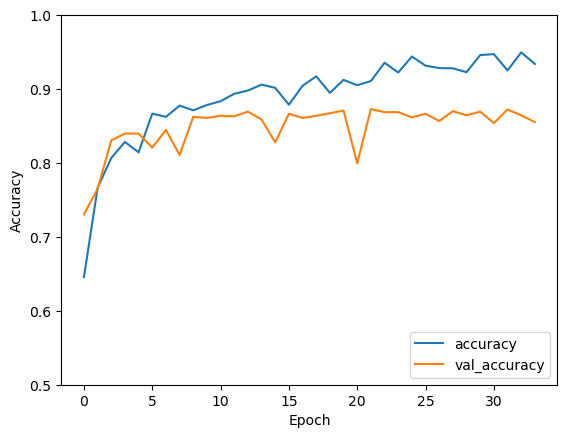

37/37 [==============================] - 9s 238ms/step
[0.8619813717188822, 0.8399339933993399, 0.8852173913043478, [[509, 97], [66, 503]]]
[1090250, 872328, 1086282, 30273, 884553, 920408, 872093, 872115, 111352, 872167, 327282, 845620, 872118, 872169, 605838, 997171, 251433, 327284, 704710, 7560, 245444, 929890, 872324, 200688, 459996, 1060641, 798048, 29283, 493855, 569768, 365474, 974199, 845595, 469099, 213000, 979305, 753397, 845606, 605842, 575019, 872367, 29271, 872361, 765295, 784086, 29274, 81987, 1058688, 731566, 1043864, 974214, 775797, 327322, 974196, 433117, 111369, 351086, 520812, 111348, 286057, 784073, 327312, 845622, 830687, 934593, 460022]
[952524, 852770, 527850, 1059310, 657693, 117607, 66092, 178333, 258621, 269904, 307353, 66105, 214636, 447985, 236277, 419852, 853736, 118791, 457741, 35375, 861920, 430379, 940828, 584068, 311884, 589667, 858137, 710356, 753863, 692603, 751789, 269950, 587936, 244858, 211240, 711239, 347492, 753035, 459798, 121499, 613274, 66097,

Text(0, 0.5, 'Actual class')

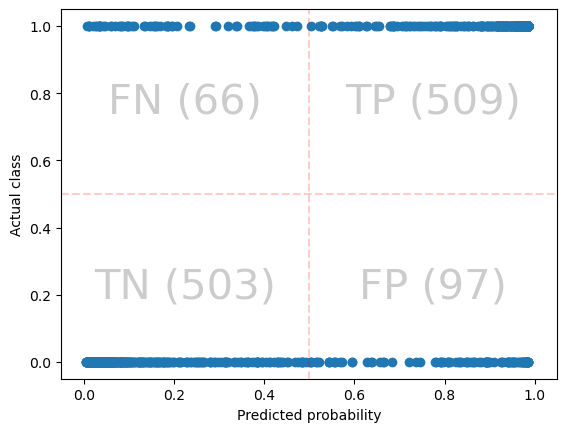

In [212]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)
measIDs_FN = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

plt.scatter(pred_prob, ytest)
plt.hlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.vlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.text(0.775, 0.775, 'TP ('+str(p[3][0][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.775, 0.225, 'FP ('+str(p[3][0][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.775, 'FN ('+str(p[3][1][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.225, 'TN ('+str(p[3][1][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Predicted probability')
plt.ylabel('Actual class')

In [213]:
# print(meas_test)
meas_pt_test =  list(measIDs_pt_test_AF) + list(measIDs_pt_test_noAF)
xtest_pt_unfilt, meas_pt_test = ecg.store_ecg_data(measIDs=meas_pt_test, study='trial', permute = False)
print(meas_pt_test)
print('Extracted data')
xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
print('Filtered data')
ytest_pt = np.array([1]*len(measIDs_pt_test_AF) + [0]*len(measIDs_pt_test_noAF))
print('Produced classes')

100%|██████████| 3143/3143 [02:04<00:00, 25.30it/s]


[525114, 689270, 300983, 381487, 300933, 983821, 39286, 53494, 39322, 300927, 568483, 300963, 1006169, 891571, 300980, 300989, 154764, 671235, 1006142, 39309, 825244, 39281, 39377, 39279, 891598, 114569, 524420, 25786, 30187, 39346, 568493, 525155, 300985, 39325, 300981, 300925, 207011, 891617, 39333, 891558, 567151, 39337, 568416, 30184, 1006217, 300924, 53525, 860261, 39359, 53508, 525171, 53530, 300923, 983822, 111426, 300953, 179843, 53499, 1006203, 1006180, 126316, 1006213, 300936, 891614, 39336, 300904, 1088392, 39367, 39370, 524419, 39380, 525154, 53509, 622773, 351950, 300978, 300969, 568415, 739086, 53519, 39386, 39283, 567135, 823345, 30190, 179870, 39303, 891582, 53510, 53528, 498234, 894698, 568430, 1042977, 53488, 39321, 30189, 53471, 957550, 567113, 559520, 891632, 1006183, 959169, 186098, 605616, 891631, 39366, 434906, 154790, 1006181, 759766, 53474, 39371, 1006161, 300961, 39297, 1022301, 39304, 1006150, 1042958, 130272, 815888, 300957, 53496, 963667, 1006162, 689297, 3

In [214]:
# TP, FP, FN, TN = 0, 0, 0, 0

# pt_results = []
# for i in pt_test:
#     pt_measIDs = ecg.extract_pt_measIDs(i, study = 'trial')
#     pt_measIDs = [i for i in pt_measIDs if i in meas_test and ecg.extract_measDiag([i])[0] != 5]
#     pt_diag = ecg.extract_ptDiag(i, study = 'trial')
#     if len(pt_measIDs) != 0:
#         xtest_pt_unfilt, meas_pt_test = ecg.store_ecg_data(measIDs=pt_measIDs, study='trial', permute = False)
#         xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
#         pred_prob = cnn.predict(xtest_pt, verbose = 0)
#         ypred_pt = np.round(pred_prob)
#         if 1 in ypred_pt:
#             pt_pred_diag = 1
#         else:
#             pt_pred_diag = 3
#     else:
#         pt_pred_diag = 3

#     if pt_diag == pt_pred_diag:
#         if pt_pred_diag == 1: TP += 1
#         if pt_pred_diag == 3: TN += 1
#     else:
#         if pt_pred_diag == 3: FN += 1
#         if pt_pred_diag == 1: FP += 1
    
#     pt_results.append([i, pt_diag, pt_pred_diag])

# print([[TP, FP], [FN, TN]])

In [215]:
TP, FP, FN, TN = 0, 0, 0, 0
print(pt_test)
pt_measIDs_lens = []
pt_measIDs_global = []
pt_diags = []
for i in tqdm(pt_test):
    pt_measIDs = ecg.extract_pt_measIDs(i, study = 'trial')
    pt_measIDs_lens.append(0)
    for j in pt_measIDs:
        if j in meas_test:
            pt_measIDs_global.append(j)
            pt_measIDs_lens[-1] += 1

    pt_diags.append(ecg.extract_ptDiag(i, study = 'trial'))
xtest_pt_unfilt, pt_measIDs_global = ecg.store_ecg_data(measIDs=pt_measIDs_global, study='trial', permute = False)
xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
pred_prob = cnn.predict(xtest_pt, verbose = 0)
ypred_pt = np.round(pred_prob)

# j = 0
# for i in tqdm(range(len(pt_test))):

#     if 1 in ypred_pt[j:j+pt_measIDs_lens[i]]:
#         pt_pred_diag = 1
#     else:
#         pt_pred_diag = 3
    
#     if pt_diags[i] == pt_pred_diag:
#         if pt_pred_diag == 1: TP += 1
#         if pt_pred_diag == 3: TN += 1
#     else:
#         if pt_pred_diag == 3: FN += 1
#         if pt_pred_diag == 1: FP += 1

# print([[TP, FP], [FN, TN]])

[2796, 9805, 11587, 57, 1154, 10833, 8175, 5585, 2694, 717, 646, 475, 13310, 544, 622, 6138, 5719, 7783, 4279, 6526, 4507, 6921, 7430, 10158, 9193, 8120, 3861, 13363, 4805, 9877, 636, 4088, 11832, 6261, 564, 11042, 1347, 1455, 8206, 1377, 13049, 5386, 4849, 9715, 4784, 7942, 10166, 10015, 1156, 4123, 10435, 11693, 6384, 9650, 2941, 8905, 12584, 12002, 9603, 2354, 1389, 5599, 10595, 6659, 8767, 5583, 5899, 13010, 5838, 9204, 2626, 1067, 7641, 9668, 5136, 7574, 8036, 3612, 7926, 8210, 4815, 3249, 11125, 10688, 995, 12270, 6529, 4704, 9994, 12651, 9523, 1717, 5466, 1967, 11663, 5567, 8501, 12235, 12390, 5551, 13203, 11642, 8199, 11093, 12978, 10732, 4267, 11299, 2986, 11339, 1892, 7739, 10215, 10896, 12202, 2248, 2854, 6061, 11307, 10063, 2707, 2220, 5832, 4359, 5013, 6038, 10321, 361, 71, 7314, 2380, 7702, 3031, 669, 12812, 11080, 7785, 2219, 8916, 6338, 5602, 7461, 2227, 10541, 1539, 4472, 1796, 1751, 12648, 6629, 11174, 2635, 3930, 4889, 39, 12639, 3539, 12317, 1573, 10374, 6184, 12567

100%|██████████| 41735/41735 [24:57<00:00, 27.87it/s]
C:\Users\docto\AppData\Local\Temp\ipykernel_51664\2357387236.py:27: RuntimeWarning: invalid value encountered in divide
  norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))


In [225]:
TP, FP, FN, TN = 0, 0, 0, 0

def F1_patients(conf_m):
    return 2*conf_m[0][0]/(2*conf_m[0][0] + conf_m[0][1] + conf_m[1][0])

max_F1 = 0
threshes = np.linspace(0, 1, 1000)
# for thresh in tqdm(threshes):
for thresh in [0.95, 0.96, 0.97, 0.98, 0.99]:
    TP, FP, FN, TN = 0, 0, 0, 0
    j = 0
    for i in range(len(pt_test)):
        if pt_measIDs_lens[i] == 0:
            linfnorm = 0
        else:
            linfnorm = max(pred_prob[j:j+pt_measIDs_lens[i]])
        if linfnorm > thresh:
            pt_pred_diag = 1
        else:
            pt_pred_diag = 3

        if pt_diags[i] == pt_pred_diag:
            if pt_pred_diag == 1: TP += 1
            if pt_pred_diag == 3: TN += 1
        elif pt_diags[i] != 2:
            if pt_pred_diag == 3: FN += 1
            if pt_pred_diag == 1: FP += 1
        j += pt_measIDs_lens[i]
    # if F1_patients([[TP, FP],[FN, TN]]) > max_F1 and TP/(TP + FN) > 0.98:
    if F1_patients([[TP, FP],[FN, TN]]) > max_F1:
        max_conf_m, max_F1, max_thresh = [[TP, FP],[FN, TN]], F1_patients([[TP, FP],[FN, TN]]), thresh

    print(max_conf_m, max_F1, max_thresh)

[[89, 168], [19, 1355]] 0.4876712328767123 0.95
[[86, 146], [22, 1377]] 0.5058823529411764 0.96
[[83, 122], [25, 1401]] 0.5303514376996805 0.97
[[76, 70], [32, 1453]] 0.5984251968503937 0.98
[[76, 70], [32, 1453]] 0.5984251968503937 0.98


In [233]:
def F1_patients(conf_m):
    return 2*conf_m[0][0]/(2*conf_m[0][0] + conf_m[0][1] + conf_m[1][0])

max_F1 = 0
threshes = np.linspace(0.0, 1.001, 1000)

for thresh in tqdm(threshes):
# for thresh in [0.155, 0.157, 0.16, 0.163]:
    TP, FP, FN, TN = 0, 0, 0, 0
    j = 0
    for i in range(len(pt_test)):
        if pt_measIDs_lens[i] == 0:
            l1norm = 0
        else:
            l1norm = np.mean(pred_prob[j:j+pt_measIDs_lens[i]])
        
        if l1norm > thresh:
            pt_pred_diag = 1
        else:
            pt_pred_diag = 3
        
        if pt_diags[i] == pt_pred_diag:
            if pt_pred_diag == 1: TP += 1
            if pt_pred_diag == 3: TN += 1
        elif pt_diags[i] != 2:
            if pt_pred_diag == 3: FN += 1
            if pt_pred_diag == 1: FP += 1
        j += pt_measIDs_lens[i]
    if F1_patients([[TP, FP],[FN, TN]]) > max_F1 and TP/(TP + FN) > 0.98:
    # if F1_patients([[TP, FP],[FN, TN]]) > max_F1:
        max_conf_m, max_F1, max_thresh = [[TP, FP],[FN, TN]], F1_patients([[TP, FP],[FN, TN]]), thresh
print(max_conf_m, max_F1, max_thresh)   

100%|██████████| 1000/1000 [00:26<00:00, 37.40it/s]

[[106, 648], [2, 875]] 0.2459396751740139 0.07314614614614615


In [243]:
max_F1 = 0
threshes = np.linspace(0, 1, 1000)

for n in range(1, 10):
    for thresh in tqdm(threshes):
        TP, FP, FN, TN = 0, 0, 0, 0
        j = 0
        for i in range(len(pt_test)):
            if pt_measIDs_lens[i] == 0:
                l1norm = 0
            else:
                l1norm = np.mean(np.flip(np.sort(pred_prob[j:j+pt_measIDs_lens[i]]))[:n])
            if l1norm > thresh:
                pt_pred_diag = 1
            else:
                pt_pred_diag = 3
            
            if pt_diags[i] == pt_pred_diag:
                if pt_pred_diag == 1: TP += 1
                if pt_pred_diag == 3: TN += 1
            elif pt_diags[i] != 2:
                if pt_pred_diag == 3: FN += 1
                if pt_pred_diag == 1: FP += 1
            j += pt_measIDs_lens[i]
        # if F1_patients([[TP, FP],[FN, TN]]) > max_F1 and TP/(TP + FN) > 0.85:
        if F1_patients([[TP, FP],[FN, TN]]) > max_F1:
            max_conf_m, max_F1, max_thresh = [[TP, FP],[FN, TN]], F1_patients([[TP, FP],[FN, TN]]), thresh
    print(max_conf_m, max_F1, max_thresh, n)

100%|██████████| 1000/1000 [00:37<00:00, 26.68it/s]


[[44, 56], [64, 1467]] 0.4230769230769231 0.7657657657657657 1


100%|██████████| 1000/1000 [00:37<00:00, 26.71it/s]


[[54, 73], [54, 1450]] 0.4595744680851064 0.5105105105105106 2


100%|██████████| 1000/1000 [00:37<00:00, 26.54it/s]


[[45, 27], [63, 1496]] 0.5 0.6566566566566566 3


100%|██████████| 1000/1000 [00:36<00:00, 27.11it/s]


[[45, 27], [63, 1496]] 0.5 0.6566566566566566 4


100%|██████████| 1000/1000 [00:37<00:00, 26.94it/s]


[[49, 31], [59, 1492]] 0.5212765957446809 0.5765765765765766 5


100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s]


[[53, 36], [55, 1487]] 0.5380710659898477 0.5215215215215215 6


100%|██████████| 1000/1000 [00:38<00:00, 25.83it/s]


[[57, 44], [51, 1479]] 0.5454545454545454 0.4974974974974975 7


100%|██████████| 1000/1000 [00:37<00:00, 26.43it/s]


[[56, 39], [52, 1484]] 0.5517241379310345 0.5095095095095095 8


100%|██████████| 1000/1000 [00:37<00:00, 26.57it/s]

[[60, 49], [48, 1474]] 0.5529953917050692 0.47347347347347346 9


In [253]:
def F1_patients(conf_m):
    return 2*conf_m[0][0]/(2*conf_m[0][0] + conf_m[0][1] + conf_m[1][0])

max_F1 = 0
threshes = np.linspace(0, 1, 1000)

for thresh in tqdm(threshes):
# for thresh in [0.02]:
    TP, FP, FN, TN = 0, 0, 0, 0
    j = 0
    for i in range(len(pt_test)):
        if pt_measIDs_lens[i] == 0:
            l2norm = 0
        else:
            l2norm = np.sqrt(np.mean(pred_prob[j:j+pt_measIDs_lens[i]]**2))
        if l2norm > thresh:
            pt_pred_diag = 1
        else:
            pt_pred_diag = 3
        
        if pt_diags[i] == pt_pred_diag:
            if pt_pred_diag == 1: TP += 1
            if pt_pred_diag == 3: TN += 1
        elif pt_diags[i] != 2:
            if pt_pred_diag == 3: FN += 1
            if pt_pred_diag == 1: FP += 1
        j += pt_measIDs_lens[i]
    if F1_patients([[TP, FP],[FN, TN]]) > max_F1 and TP/(TP + FN) > 0.98:
    # if F1_patients([[TP, FP],[FN, TN]]) > max_F1:
        max_conf_m, max_F1, max_thresh = [[TP, FP],[FN, TN]], F1_patients([[TP, FP],[FN, TN]]), thresh
print(max_conf_m, max_F1, max_thresh)



100%|██████████| 1000/1000 [00:28<00:00, 35.28it/s]

[[106, 557], [2, 966]] 0.27496757457846954 0.15215215215215216


In [ ]:
# max_F1 = 0
# threshes = np.linspace(0, 1, 1000)

# for n in range(9, 20):
#     for thresh in tqdm(threshes):
#         TP, FP, FN, TN = 0, 0, 0, 0
#         j = 0
#         for i in range(len(pt_test)):
#             if pt_measIDs_lens[i] == 0:
#                 l2norm = 0
#             else:
#                 l2norm = np.mean(np.flip(np.sort(pred_prob[j:j+pt_measIDs_lens[i]]))[:n]**2)
#             if l2norm > thresh:
#                 pt_pred_diag = 1
#             else:
#                 pt_pred_diag = 3
            
#             if pt_diags[i] == pt_pred_diag:
#                 if pt_pred_diag == 1: TP += 1
#                 if pt_pred_diag == 3: TN += 1
#             elif pt_diags[i] != 2:
#                 if pt_pred_diag == 3: FN += 1
#                 if pt_pred_diag == 1: FP += 1
#             j += pt_measIDs_lens[i]
#         if F1_patients([[TP, FP],[FN, TN]]) > max_F1 and TP/(TP + FN) > 0.85:
#             max_conf_m, max_F1, max_thresh = [[TP, FP],[FN, TN]], F1_patients([[TP, FP],[FN, TN]]), thresh
#     print(max_conf_m, max_F1, max_thresh, n)

In [ ]:
pred_prob = cnn.predict(xtest_pt)
ypred_pt = np.round(pred_prob)
print(len(ypred_pt))
p = performance(ytest_pt, ypred_pt)
print('Performance: ', p)
measIDs_wrong = [meas_pt_test[i] for i in range(len(ytest_pt)) if ytest_pt[i] != ypred_pt[i]]
print('Found incorrect measIDs')
pt_wrong = []
for i in measIDs_wrong:
    for j in ecg_tags_reviewed:
        if j[2] == i and j[0] not in pt_wrong:
            pt_wrong.append(j[0])
print('Patients sent to review')
nptAF = sum([1 for i in pt_test if i in patients_AF])
FP = sum([1 for i in pt_wrong if i not in patients_AF])
FN = sum([1 for i in pt_wrong if i in patients_AF])
TP = nptAF - FN
TN = len(pt_test) - FP - FN - TP
print([[TP, FP], [FN, TN]])

56/56 [==============================] - 3s 54ms/step
1784
Performance:  [0.6869565217391305, 0.5791788856304986, 0.844017094017094, [[395, 287], [73, 1029]]]
Found incorrect measIDs
Patients sent to review
[[56, 174], [37, 1369]]


In [ ]:
xtrain = np.array(filter_signals(data_train))
xval = np.array(filter_signals(data_val))
xtest = np.array(filter_signals(data_test))

print(sum(ytrain), sum(yval), sum(ytest))

ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)

1600 817 787
Epoch 1/24
100/100 [==============================] - 40s 385ms/step - loss: 0.7108 - accuracy: 0.5219 - val_loss: 0.6746 - val_accuracy: 0.5417
Epoch 2/24
100/100 [==============================] - 41s 408ms/step - loss: 0.6724 - accuracy: 0.5612 - val_loss: 0.6405 - val_accuracy: 0.6246
Epoch 3/24
100/100 [==============================] - 37s 373ms/step - loss: 0.5553 - accuracy: 0.7297 - val_loss: 0.4698 - val_accuracy: 0.7953
Epoch 4/24
100/100 [==============================] - 38s 379ms/step - loss: 0.4790 - accuracy: 0.7806 - val_loss: 0.4490 - val_accuracy: 0.7922
Epoch 5/24
100/100 [==============================] - 40s 403ms/step - loss: 0.4254 - accuracy: 0.8097 - val_loss: 0.3715 - val_accuracy: 0.8423
Epoch 6/24
100/100 [==============================] - 42s 425ms/step - loss: 0.3948 - accuracy: 0.8300 - val_loss: 0.3983 - val_accuracy: 0.8225
Epoch 7/24
100/100 [==============================] - 40s 405ms/step - loss: 0.3888 - accuracy: 0.8334 - val_loss: 0.

In [ ]:
print(performance(ytest, ypred))
measIDs_FN = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

[0.842042042042042, 0.792090395480226, 0.8987179487179487, [[701, 184], [79, 622]]]
[496976, 327322, 91565, 1025577, 872325, 327304, 962189, 1006147, 233568, 964470, 623142, 226845, 430444, 934535, 300914, 845602, 801206, 1076246, 956717, 974257, 723479, 519785, 335117, 135380, 434145, 858600, 519063, 959186, 775797, 365475, 731566, 370823, 193490, 825244, 1043861, 53503, 340794, 351007, 327312, 872327, 41850, 1018344, 438286, 1025579, 929890, 340787, 1006211, 68942, 300940, 245444, 845589, 661364, 135333, 233594, 438119, 25786, 365061, 845611, 245445, 789429, 368871, 17576, 974196, 213000, 690141, 1048718, 370824, 798086, 845655, 704709, 217965, 469099, 845622, 351000, 1007193, 1043862, 523528, 974199, 327274]
[949799, 1072101, 399944, 559522, 63372, 1067092, 6728, 482446, 340118, 3148, 231908, 262785, 745957, 1020587, 1069609, 518739, 188170, 102105, 1064884, 845996, 309543, 381384, 45662, 447987, 567570, 432432, 713528, 918896, 1093946, 961656, 481084, 445417, 707950, 949851, 106709

In [ ]:
# start, end = 6000, 10000

# for i in measIDs_FN:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Negative for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FN\FN'+str(i)+'.png', bbox_inches='tight')

# for i in measIDs_FP:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Positive for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FP\FP'+str(i)+'.png', bbox_inches='tight')

24.525061124694375


Text(0.5, 1.0, 'AF participants')

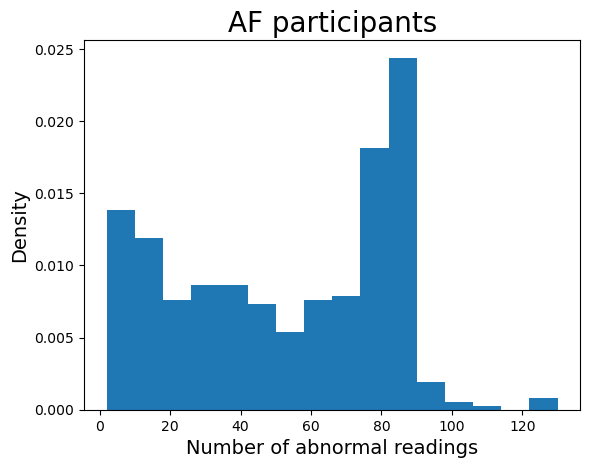

In [ ]:
histbaby = []
patients_epic = [i[0] for i in ecg.tags_pt_info_t if not ecg.test_clean(i[2], study = "trial") and ecg.extract_measDiag([i[2]]) != 5]

for i in patients_AF:
    histbaby.append(patients_epic.count(i))

# for i, j in zip(pt_diags, pt_measIDs_lens):
#     if i == 1: histbaby.append(j)

print(np.mean(pt_measIDs_lens))
plt.hist(histbaby, 16, density=True)
plt.xlabel("Number of abnormal readings", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("AF participants", fontsize=20)

In [ ]:
print(np.mean(histbaby), np.std(histbaby))
print(np.mean(pt_measIDs_lens), np.std(pt_measIDs_lens))

51.64859002169197 29.869313019685045
24.525061124694375 24.087071734683004


In [1]:
plt.hist(histbaby, 16, density=True)
plt.xlabel("Number of abnormal readings", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("All participants", fontsize=20)

NameError: name 'plt' is not defined

[[     1      4      1      6]
 [     1      4      2      6]
 [     1      4      3      6]
 ...
 [  2130      4 162256      6]
 [  2130      4 162257      6]
 [  2130      4 162258      6]]
14.945454545454545 20.021277937432814
[5, 5, 10, 1, 2, 80, 3, 1, 35, 22, 4, 6, 64, 8, 1, 46, 3, 18, 22, 9, 29, 4, 9, 1, 4, 2, 19, 4, 39, 53, 11, 19, 2, 95, 1, 29, 3, 8, 11, 10, 3, 1, 2, 2, 18, 35, 5, 10, 1, 11, 26, 4, 2, 2, 2]


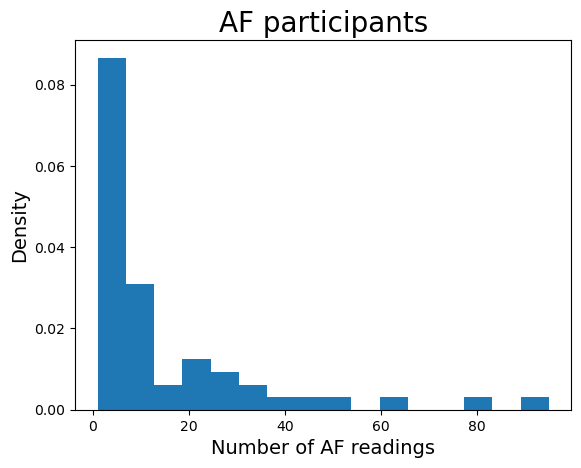

In [ ]:
patients_legend = [i[0] for i in ecg.tags_pt_info_1 if i[3] == 2]
print(ecg.tags_pt_info_1)
monke = []
for i in range(ecg.pt_num_1):
    if patients_legend.count(i) > 0:
        monke.append(patients_legend.count(i))

plt.hist(monke, 16, density=True)
plt.xlabel("Number of AF readings", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("AF participants", fontsize=20)

print(np.mean(monke), np.std(monke))
print(monke)

12
12


Text(0, 0.5, 'Voltage')

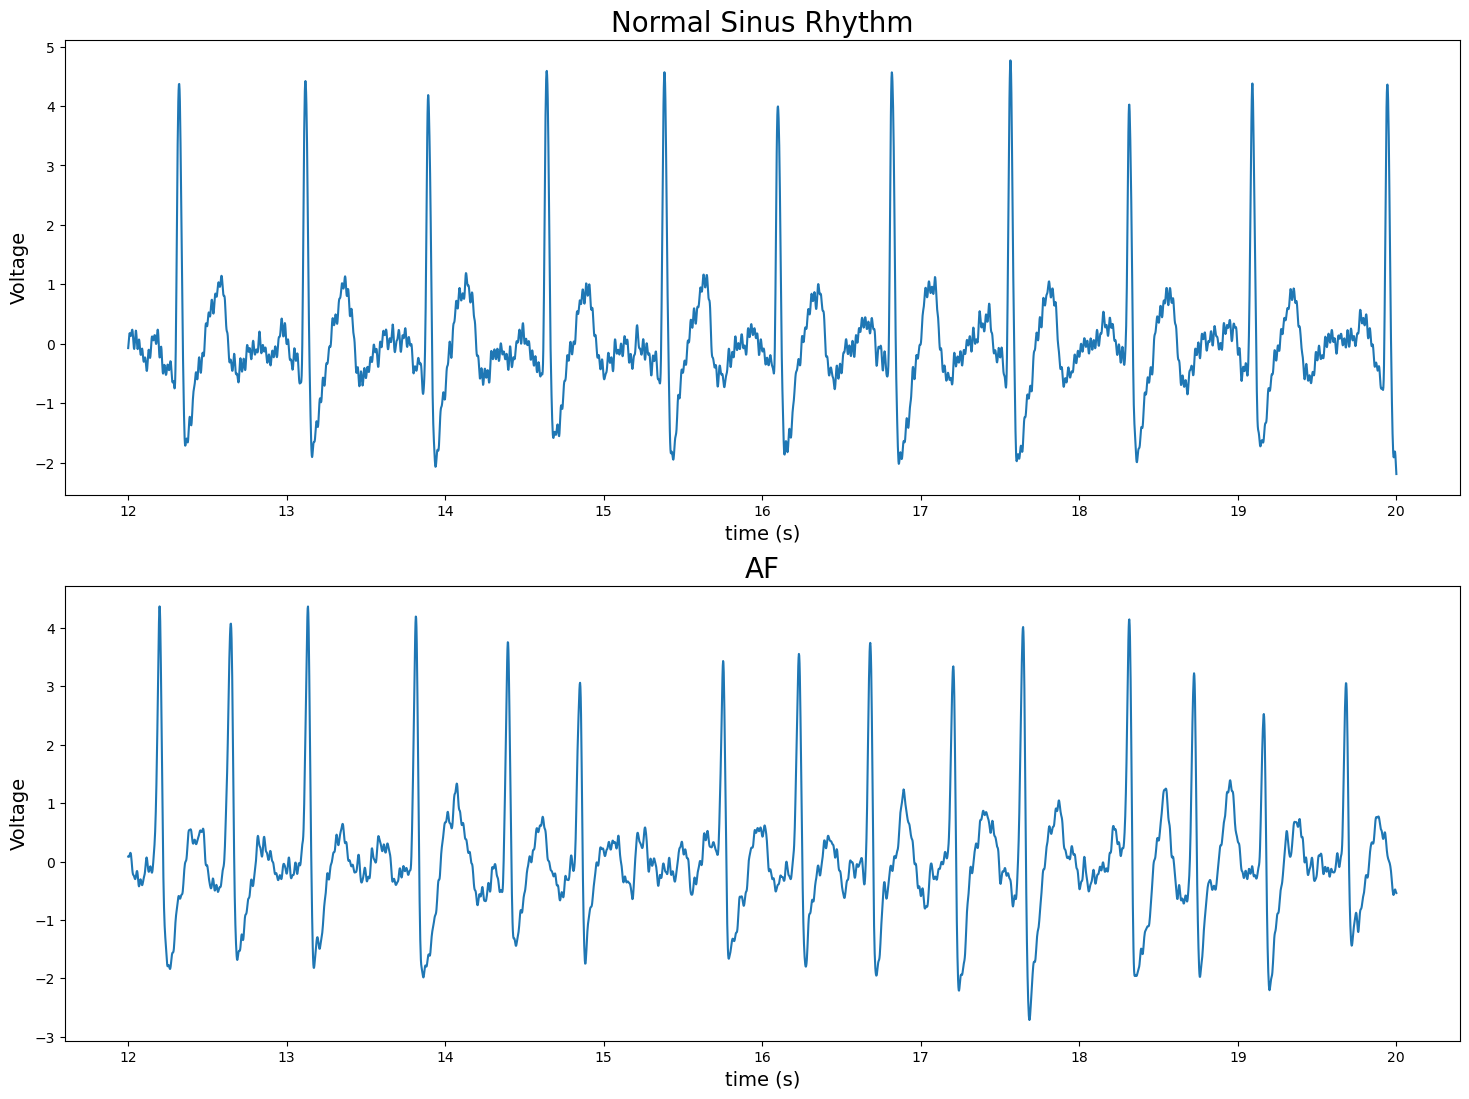

In [255]:
start, end = 6000, 10000
i = 8986
x = np.linspace(start/500, end/500, end-start)
fig, ax = plt.subplots(2,1)
fig.set_figwidth(18)
fig.set_figheight(13)
ax[0].plot(x, filter_signals([ecg.extract_signal(235645, study='trial')], high_cut=40)[0][start:end])
ax[0].set_title('Normal Sinus Rhythm', fontsize=20)
ax[0].set_xlabel('time (s)', fontsize=14)
ax[0].set_ylabel('Voltage', fontsize=14)

ax[1].plot(x, filter_signals([ecg.extract_signal(8986, study='trial')], high_cut=40)[0][start:end])
# ax[1].plot(x, ecg.extract_signal(i, study='trial')[start:end])
ax[1].set_title('AF', fontsize=20)
ax[1].set_xlabel('time (s)', fontsize=14)
ax[1].set_ylabel('Voltage', fontsize=14)
